# Reconocimineto de escenas usando SIFT-BoVW

In [1]:
!pwd

/home/mario/Documents/ScenesRecognition-AYUDAME/BoVW


In [2]:
from BoVW import *
from Image_Descriptor import *
import cv2 as cv
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

## Extracción de características

Obtención de las rutas de las muestras

In [3]:
dataset_path = "../Proyecto_AYUDAME_Datasets/Microsoft_7scenes_rgb"
filenames,label_ids,labels = prepareFiles(dataset_path)

In [4]:
# Encuentra las etiquetas distintas
labels_uk = np.unique(labels)

División de datos en entrenamiento y prueba

In [5]:
filenames_train, filenames_test, y_train, y_test = train_test_split(filenames, label_ids,
    shuffle = True, random_state = 8)

Se almacenan los valores objetivo para su posterior uso.

In [6]:
np.save("y_train_sift_01",y_train)
np.save("y_test_sift_01",y_test)
np.save("labels_uk_sift_01",labels_uk)

### Obtención de descriptores de entrenamiento

In [7]:
descriptor = cv.SIFT_create()

In [6]:
kpts_train,dscs_train = getKeypointsDescriptors(filenames_train,descriptor)

Extracting Local Descriptors


100%|██████████| 4875/4875 [08:22<00:00,  9.70it/s]

Done in 502.69193959236145 secs.


Se almacenan los descriptores porque su extracción es un proceso **altamente pesado**.

No se almacena la lista de puntos clave porque es una lista de objetos complejos que no se permiten serializar directamente, además, el método de BoVW simple (el método que se utilizará en este notebook) solo utiliza la lista de descriptores, no la de puntos clave, por lo que no es necesaria.  En caso de requerirse almacenar la lista de puntos clave se debe representar cada punto clave como una tupla con las propiedades de dichos puntos clave, tal como se realiza en este post https://stackoverflow.com/questions/10045363/pickling-cv2-keypoint-causes-picklingerror/11985056#11985056.

In [13]:
# Para almacenar se usa dump
# dump(dscs_train, "dscs_train_01.joblib")

['dscs_train_01.joblib']

In [6]:
# En caso de requerir leer el archivo almacenado
dscs_train = load("dscs_train_01.joblib")

Se revisa el número de descriptores de entrenamiento

In [14]:
dscs_train_np = np.vstack(dscs_train)
dscs_train_np.shape

(3719635, 128)

### Obtención de descriptores de prueba


In [8]:
kpts_test,dscs_test = getKeypointsDescriptors(filenames_test,descriptor)

Extracting Local Descriptors


100%|██████████| 1625/1625 [02:46<00:00,  9.77it/s]

Done in 166.2761881351471 secs.


Se almacenan los descriptores porque su extracción es un proceso **altamente pesado**.

In [9]:
# Para almacenar se usa dump
# dump(dscs_test, "dscs_test_01.joblib")

['dscs_test_01.joblib']

In [7]:
# En caso de requerir leer el archivo almacenado
dscs_test = load("dscs_test_01.joblib")

Se revisa el número de descriptores de prueba

In [10]:
dscs_test_np = np.vstack(dscs_test)
dscs_test_np.shape

(1237695, 128)

## Generación de vocabulario de palabras visuales

In [8]:
# Número de puntos de interés que se utilizan para obtener el vocabulario visual
num_samples=150000
# Número de palabras en el vocabulario visual
k=1024

In [11]:
codebook = getCodebook(dscs_train,k,num_samples,13)

Computing kmeans on 150000 samples with 1024 centroids
Done in 823.5256533622742 secs.


Se almacena el codebook porque su generación es un proceso **altamente pesado**.

In [13]:
np.save("codebook_sift_01",codebook)

In [ ]:
# En caso de requerir leer el archivo almacenado
# codebook = np.load("codebook_sift_01.npy")

In [14]:
codebook.shape

(1024, 128)

## Representación de las imágenes

Representación de los datos de entrenamiento

In [16]:
vw_train = getBoVWRepresentation(dscs_train,codebook)

Extracting visual word representations
Done in 34.53639531135559 secs.


In [17]:
vw_train.shape

(4875, 1024)

Representación de los datos de prueba

In [18]:
vw_test = getBoVWRepresentation(dscs_test,codebook)

Extracting visual word representations
Done in 17.244239568710327 secs.


## Entrenamiento del clasificador
Se entrena Support Vector Machine utilizando las representaciones de palabras visuales del conjunto de entrenamiento.

En primer lugar, se realiza validación cruzada para encontrar los parámetros optimos del clasificador.

In [23]:
# Parámetros para realizar la validación cruzada en el aprendizaje del clasificador
# folds: no de particioines
# start, end: valor inicial y final del factor de regularización C que se validaran
# numparams: no de valores diferentes para el factor de regularización C entre start y end que se van a validar
folds=5
start=0.01
end=10
numparams=15

In [24]:
%%time
train = vw_train
stdSlr = StandardScaler().fit(train)
train = stdSlr.transform(train)
tuned_parameters = [{"kernel": ["linear"], "C":np.linspace(start,end,num=numparams)}]
# tuned_parameters = [{"kernel": ["linear", "poly", "rbf", "sigmoid"], "C":[1]}]
clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=folds,scoring="accuracy")
clf.fit(train, y_train)
print(clf.best_params_)

{'C': 0.01, 'kernel': 'linear'}
CPU times: user 5min 43s, sys: 3.82 s, total: 5min 47s
Wall time: 5min 52s


Una vez obtenidos los parámetros óptimos, se entrena el modelo.

In [25]:
train = vw_train
stdSlr = StandardScaler().fit(train)
train = stdSlr.transform(train)

In [26]:
%%time
classifier = svm.SVC(C=0.01,kernel='linear').fit(train,y_train)

CPU times: user 5.29 s, sys: 115 ms, total: 5.41 s
Wall time: 5.48 s


Exactitud del modelo frente a los datos de entrenamiento

In [27]:
%%time
100*classifier.score(train, y_train)

CPU times: user 6.28 s, sys: 76 ms, total: 6.36 s
Wall time: 6.43 s


100.0

Exatitud del modelo frente a los datos de prueba

In [28]:
test = vw_test
test = stdSlr.transform(test)

In [29]:
%%time
100*classifier.score(test, y_test)

CPU times: user 2.09 s, sys: 26.9 ms, total: 2.11 s
Wall time: 2.13 s


99.93846153846154

## Evaluación de resultados

In [30]:
test_pred = classifier.predict(test)

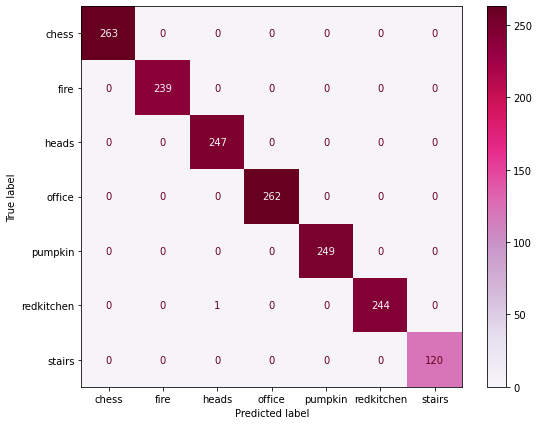

In [31]:
fig, ax = plt.subplots(figsize=(9,7))
cmd = ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=test_pred,
                                              ax=ax,cmap='PuRd',display_labels=labels_uk)
plt.show()

In [32]:
print(classification_report(y_true=y_test,y_pred=test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       263
           1       1.00      1.00      1.00       239
           2       1.00      1.00      1.00       247
           3       1.00      1.00      1.00       262
           4       1.00      1.00      1.00       249
           5       1.00      1.00      1.00       245
           6       1.00      1.00      1.00       120

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



## Persistencia del modelo

Se almacena el clasificador

In [33]:
dump(classifier, "model_sift_01.joblib")

['model_sift_01.joblib']

Se almacena el estandarizador

In [34]:
dump(stdSlr,"standard_scaler_sift_01.joblib")

['standard_scaler_sift_01.joblib']